In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import binom
import matplotlib.pyplot as plt
import matplotlib as mpl

Identify all the different combinations of parameters

_62_ different ballpark ballpark coefficients $\beta$ share a common normal distribution,
$$\beta_l \sim \text{Normal}(0, \tau^2) \quad \forall \quad l=1,...,62$$

_9L_ different spline coefficients needed for modeling position-age trajectories,
$$\gamma_{kl} \sim \text{Normal}(0, \tau^2) \quad \forall \quad k=1,...,9 \quad l=1,...,L$$

_9_ tuples, 2 values for each position $\mathbf{\alpha_k} = (\alpha_{k0}, \alpha_{k1})$,
$$\mathbf{\alpha_k} \sim \text{MVNormal}(\mathbf{0}, \tau^2\mathbf{I_2}\cdot\text{Ind}(\alpha_{k0}, \alpha_{k1})) \quad \forall \quad k = 1,...,9$$

_18_ position specific transition parameters for our elite status
$$(\nu_{00k}, \nu_{01k}) \sim \text{Dirichlet}(\omega, \omega) \quad \forall \quad k=1,...,9$$
$$(\nu_{10k}, \nu_{11k}) \sim \text{Dirichlet}(\omega, \omega) \quad \forall \quad k=1,...,9$$

Player-year rate $\theta_{ij}$ as a function of home ballpark $b=B_{ij}$, position $k=R_{ij}$ and age $A_{ij}$ of player $i$ in year $j$
$$\text{log}(\frac{\theta_{ij}}{1-\theta_{ij}})=\alpha_k+\beta_b+f_k(A_{ij})$$

In [2]:
def dark_theme(active=True):
    '''
    Still need to run magic command: %matplotlib inline
    rcParams keys:
    Note: plt.style.use('ggplot') will not work w/ these settings
    Face Color Reference
    https://www.webucator.com/blog/2015/03/python-color-constants-module/
    '''
    if active == True:
        import matplotlib as mpl
        from cycler import cycler
        mpl.rcParams['figure.figsize'] = 12, 8
        mpl.rcParams['text.color'] = 'w'
        mpl.rcParams['font.size'] = 10.0
        mpl.rcParams['xtick.color'] = 'w'
        mpl.rcParams['xtick.direction'] = 'out'
        mpl.rcParams['ytick.color'] = 'w'
        mpl.rcParams['ytick.direction'] = 'out'
        mpl.rcParams['axes.labelcolor'] = 'w'
        mpl.rcParams['axes.labelsize'] = 'x-large'
        mpl.rcParams['axes.titlesize'] = 'xx-large'
        mpl.rcParams['axes.facecolor'] = 'silver' # '#FFFFFF' # Background color e.g. #E5E5E5 = ggplot style, #BFEFFF light blue
        mpl.rcParams['axes.linewidth'] = 1.0
        mpl.rcParams['axes.axisbelow'] = True
        
        mpl.rcParams['legend.facecolor'] = 'grey'
        mpl.rcParams['legend.frameon'] = True
        # mpl.rcParams['axes.edgecolor'] = 'w'
        mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
        mpl.rcParams['axes.grid'] = True
        mpl.rcParams['grid.alpha'] = 0.2
        # mpl.rcParams['grid.color'] = '#FFFFFF'
        mpl.rcParams['grid.color'] = 'k'
        mpl.rcParams['grid.linestyle'] = '-'
        mpl.rcParams['grid.linewidth'] = 1.0
    elif active == False:
        import matplotlib as mpl
        mpl.rcParams.update(mpl.rcParamsDefault)

Lookup how splines work and write some stuff about splines

In [3]:
# plt.style.use('ggplot')
dark_theme()

In [4]:
# Import cleaned test data

In [5]:
test_data = pd.read_csv('../data/processed/test_data')

In [6]:
test_data.head(20)

,playerID,yearID,HR,AB,playerAge,park,pos_main,yearsInMLB,full_name
0,ransoco01,2004,1,68,28,SBC Park,SS,4,Cody Ransom
1,torreyo01,2004,6,172,26,SBC Park,C,4,Yorvit Torrealba
2,theriry01,2006,3,134,27,Wrigley Field,2B,2,Ryan Theriot
3,credejo01,2007,4,167,29,U.S. Cellular Field,3B,8,Joe Crede
4,mackoro01,2007,6,237,31,U.S. Cellular Field,LF,7,Rob Mackowiak
5,ozunapa01,2007,0,78,33,U.S. Cellular Field,3B,8,Pablo Ozuna
6,podsesc01,2007,2,214,31,U.S. Cellular Field,LF,7,Scott Podsednik
7,uribeju01,2007,20,513,28,U.S. Cellular Field,SS,7,Juan Uribe
8,ellsbja01,2008,9,554,25,Fenway Park II,CF,2,Jacoby Ellsbury
9,thursjo01,2008,0,8,29,Fenway Park II,LF,7,Joe Thurston


In [7]:
test_data.shape

(968, 9)

In [8]:
hrs_park = test_data.groupby('park')['HR'].sum().sort_values(ascending=False)
hrs_age = test_data.groupby('playerAge')['HR'].sum().sort_values(ascending=False)
hrs_pos = test_data.groupby('pos_main')['HR'].sum().sort_values(ascending=False)

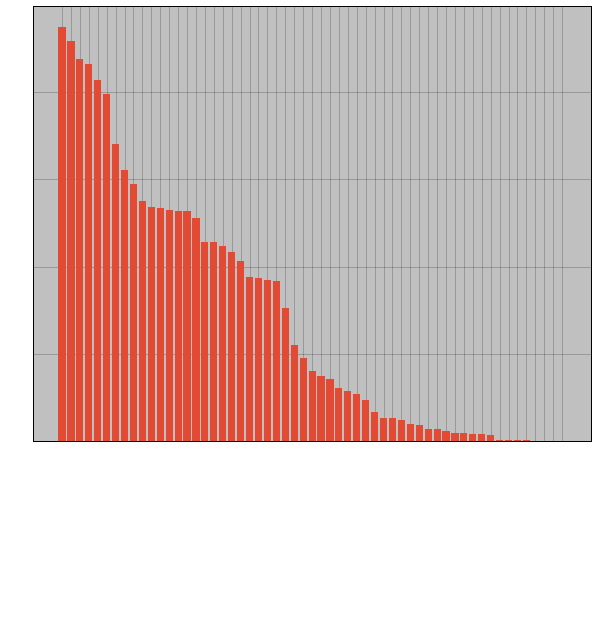

In [9]:
plt.figure(figsize=(10,8))
plt.bar(hrs_park.index, hrs_park.values)
plt.xticks(rotation=90)
plt.show()

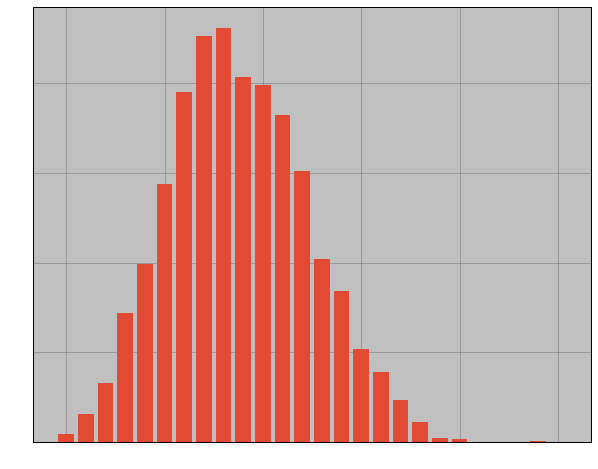

In [10]:
plt.figure(figsize=(10,8))
plt.bar(hrs_age.index, hrs_age.values)
plt.xticks(rotation=90)
plt.show()

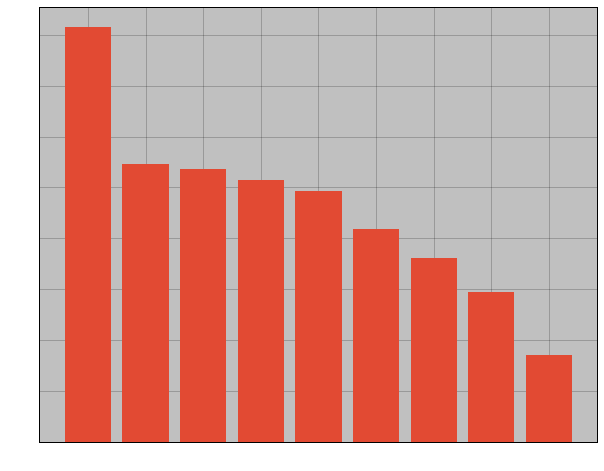

In [11]:
plt.figure(figsize=(10,8))
plt.bar(hrs_pos.index, hrs_pos.values)
plt.xticks(rotation=90)
plt.show()

In [12]:
test_data.groupby('pos_main')['playerAge'].count().sort_values(ascending=False)

pos_main
C     194
3B    123
CF    118
SS    114
LF    108
1B    108
2B     94
RF     85
DH     24
Name: playerAge, dtype: int64

Initialize elite status

In [13]:
elite_status = stats.bernoulli.rvs(p=0.1, size=len(test_data))
test_data['elite_status'] = elite_status

In [14]:
test_data = test_data.sort_values(by=['playerID', 'yearID'])

In [15]:
test_data['elite_status_prev'] = test_data.groupby('playerID')['elite_status'].shift(1)
test_data['year_in_league'] = (test_data.yearID - test_data.groupby('playerID').yearID.transform('min')) + 1

In [16]:
test_data.sort_values(by=['playerID', 'yearID'])

,playerID,yearID,HR,AB,playerAge,park,pos_main,yearsInMLB,full_name,elite_status,elite_status_prev,year_in_league
92,abreuto01,2007,2,166,23,Dodger Stadium,3B,1,Tony Abreu,0,NaN,1
94,abreuto01,2009,0,8,25,Dodger Stadium,2B,3,Tony Abreu,0,0.0,3
96,abreuto01,2010,1,193,26,Chase Field,3B,4,Tony Abreu,0,0.0,4
98,abreuto01,2012,1,70,28,Kauffman Stadium,2B,6,Tony Abreu,0,0.0,6
102,abreuto01,2013,2,138,29,AT&T Park,2B,7,Tony Abreu,1,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...
519,yelicch01,2014,9,582,23,Marlins Park,LF,2,Christian Yelich,0,0.0,2
521,yelicch01,2015,7,476,24,Marlins Park,LF,3,Christian Yelich,0,0.0,3
637,yelicch01,2016,21,578,25,Marlins Park,LF,4,Christian Yelich,0,0.0,4
600,yelicch01,2017,18,602,26,Marlins Park,CF,5,Christian Yelich,0,0.0,5


In [17]:
def theta(α, β, f_a):
    return 1 / (1 + np.exp(α + β + f_a))

In [18]:
def logit_theta(θ):
    return np.log(θ/(1-θ))

In [19]:
# def log_binom(x, n, p):
#     return np.log(stats.binom(n, p).pmf(x))

In [20]:
# def log_N(x, μ, σ):
#     return np.log(stats.norm(μ, σ).pdf(x))

In [21]:
# def log_D(x, ω: np.array):
#     return np.log(stats.dirichlet(alpha=ω).pdf(x))

In [22]:
def log_prior(alpha: dict, beta: dict, gamma: dict, nu: dict, omega: dict):
    psum = 0
    for x in beta.values():
        psum += stats.norm(0, tau).logpdf(x)
    for x in gamma.values():
        psum += stats.norm(0, tau).logpdf(x)
    for x1, x2 in alpha.values():
        psum += stats.norm(0, tau).logpdf(x1) + stats.norm(0, tau).logpdf(x2)
    # breakpoint()
    for pos_vals, pos_params in zip(nu.values(), omega.values()):
        for vals, params in zip(pos_vals, pos_params): 
            psum += stats.dirichlet.logpdf(vals, params)
    return psum

Write code for equation (9)

In [23]:
cf = test_data[test_data.pos_main == 'CF']

In [24]:
cf.sort_values(['playerID', 'yearID'])

,playerID,yearID,HR,AB,playerAge,park,pos_main,yearsInMLB,full_name,elite_status,elite_status_prev,year_in_league
792,cainlo01,2010,1,147,24,Miller Park,CF,1,Lorenzo Cain,0,NaN,1
99,cainlo01,2012,7,222,26,Kauffman Stadium,CF,3,Lorenzo Cain,0,0.0,3
952,cainlo01,2013,4,399,27,Kauffman Stadium,CF,4,Lorenzo Cain,1,0.0,4
231,cainlo01,2014,5,471,28,Kauffman Stadium,CF,5,Lorenzo Cain,0,1.0,5
400,cainlo01,2015,16,551,29,Kauffman Stadium,CF,6,Lorenzo Cain,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
433,uptonbj01,2012,28,573,28,Tropicana Field,CF,9,Melvin Upton,0,1.0,9
775,uptonbj01,2013,9,391,29,Turner Field,CF,10,Melvin Upton,0,0.0,10
777,uptonbj01,2014,12,519,30,Turner Field,CF,11,Melvin Upton,0,0.0,11
444,uptonbj01,2015,5,205,31,Petco Park,CF,12,Melvin Upton,0,0.0,12


Find transition sums $\text{N}_{00k}$, $\text{N}_{01k}$, $\text{N}_{10k}$, $\text{N}_{11k}$ where $\text{N}_{abk} = \sum_i\sum_{t=1}^{n_i}\text{I}(\text{E}_{i,t}=a, \text{E}_{i, t+1}=b)$

In [25]:
# Each position in transitions will contains the number of transitions from a,b
transitions = np.zeros((2, 2))

In [26]:
def chunks(array, n):
    for i in range(len(array)):
        yield array[i:i+n]

In [27]:
players = cf.groupby('playerID')

In [28]:
# for player in players:
#     elite_status = player[1]['elite_status'].values
#     for i in range(len(elite_status)):
#         trans = elite_status[i:i+2]
#         if len(trans) != 2:
#             continue
#         a, b = trans[0], trans[1]
#         transitions[a][b] += 1

In [29]:
# for index, player in players:
#     trans = [(e0, e1) for e0, e1 in player[['elite_status', 'elite_status_prev']].values]
#     print(f'Player Index: {index}', '\n', f'Transition: {trans}')

In [30]:
def transitions(players: pd.core.groupby.generic.DataFrameGroupBy):
    trans_out = np.zeros((2, 2))
    for index, player in players:
        elite_status = player['elite_status'].values
        for trans in chunks(elite_status, 2):
            if len(trans) != 2:
                continue
            a, b = trans[0], trans[1]
            trans_out[a][b] += 1
    return trans_out

In [31]:
def position_transitions(data: pd.DataFrame, position: str):
    position = position.upper()
    pos = data[data.pos_main == position]
    players = pos.groupby('playerID')
    return transitions(players)

In [32]:
position_transitions(data=test_data, position='cf')

array([[76., 10.],
       [ 9.,  0.]])

Update `nu_params` based on the data

In [33]:
nu_params = np.ones((9, 2, 2))

In [34]:
cf_params = position_transitions(data=test_data, position='cf')
nu_params[7] = nu_params[7] + cf_params

## TODOs:
- [x] map position transitions to dictionary
- [x] map positions to integer (0-DH, 1-C,...,8-RF)
- [ ] Implement equation 8, posterior
    - $p(\theta_{ij}|R_{ij}, A_{ij}, B_{ij}, E_{ij}, \alpha, \beta, \gamma)$ is NOT a probability, instead use equation 2 to calculate $\theta_{ij}$
    - use $p(\theta_{ij}|R_{ij}, A_{ij}, B_{ij}, E_{ij}, \alpha, \beta, \gamma)$ to then calculate $p(Y_{ij}|M_{ij}, \theta_{ij})$
    - return the log of probabilities of ALL the things
- [ ] If time permits, implement step 1-4 in 2.2

In [35]:
positions = ['C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH']
pos_index = list(range(len(positions)))
pos_map = dict(zip(pos_index, positions))

In [36]:
pos_map

{0: 'C',
 1: '1B',
 2: '2B',
 3: '3B',
 4: 'SS',
 5: 'LF',
 6: 'CF',
 7: 'RF',
 8: 'DH'}

Instantiate position $\alpha$ parameters for Dirichlet Model

In [37]:
pos_omega_params = dict(zip(positions, np.ones((9, 2, 2))))

Probably going to want to create an `update_position_transition_params` function

In [38]:
# def update_position_transition_params():

for pos in positions:
    get_transition_omegas = position_transitions(data=test_data, position=pos)
    pos_omega_params[pos] += get_transition_omegas

In [39]:
tau = 100

# Beta (Ballparks) β ~ N(0, τ2)
beta_vals = stats.norm.rvs(loc=0, scale=tau, size=len(test_data.park.unique()))

# Gamma (Spline Coefficients) γ ~ N(0, τ2)
# These will be used in our age trajectory model
gamma_vals = stats.norm.rvs(loc=0, scale=tau, size=36).reshape(9, 4)

In [40]:
# Alpha params (Position/Elite status coefficients) (α_{pos, elite0}, α2_{pos, elite1}) ~ ΜVNormal(0, τ2*Ι)
alpha_vals = stats.multivariate_normal.rvs(mean=0, cov=tau, size=(9, 2))
alpha_vals.sort()

In [41]:
alpha_vals

array([[  1.02318175,  10.58542695],
       [ -7.11842713,  -0.44409681],
       [ -8.42222917,  -0.2162805 ],
       [-12.12621562,  12.14931343],
       [ -9.5226919 ,   2.88018371],
       [-11.6668154 ,  -5.79182497],
       [ -8.38394376,   2.21474782],
       [  0.48171084,  25.28920955],
       [  4.32243927,   5.03762775]])

In [42]:
# Nu transition values
nu_vals = stats.dirichlet.rvs(alpha=np.array([1, 1]), size=18).reshape(9, 2, 2)

In [43]:
nu_vals

array([[[0.67057529, 0.32942471],
        [0.00304758, 0.99695242]],

       [[0.45486592, 0.54513408],
        [0.16106042, 0.83893958]],

       [[0.03334379, 0.96665621],
        [0.8497784 , 0.1502216 ]],

       [[0.24169845, 0.75830155],
        [0.53716657, 0.46283343]],

       [[0.70680323, 0.29319677],
        [0.16998236, 0.83001764]],

       [[0.03736928, 0.96263072],
        [0.03862694, 0.96137306]],

       [[0.28445794, 0.71554206],
        [0.80346564, 0.19653436]],

       [[0.16762282, 0.83237718],
        [0.81567637, 0.18432363]],

       [[0.14389392, 0.85610608],
        [0.50978693, 0.49021307]]])

For some player i,j look up their position, look up in `nu_vals` based on position. Find elite status this year, and elite status last year

In [45]:
# Park effect parameters
beta_params = dict(zip(test_data.park.unique(), beta_vals))

# The intercept for the model dependent on the elite status & position
alpha_params = dict(zip(positions, alpha_vals))

# Used for the ν transition probabilities dependent on the elite status & position
nu_params = dict(zip(positions, stats.dirichlet.rvs(alpha=np.array([1, 1]), size=18).reshape(9, 2, 2)))

# Used for the ν transition parameters depenent on the elite status & position
omega_params = dict(zip(positions, np.ones((9, 2, 2))))

# Used as coefficients in what I believe to be a 3rd degree polynomial regression
gamma_params = dict(zip(positions, stats.norm.rvs(loc=0, scale=tau, size=36).reshape(9, 4)))

In [46]:
nu_params

{'C': array([[0.78010585, 0.21989415],
        [0.94411664, 0.05588336]]),
 '1B': array([[0.51057328, 0.48942672],
        [0.66084919, 0.33915081]]),
 '2B': array([[0.28533944, 0.71466056],
        [0.67641289, 0.32358711]]),
 '3B': array([[0.8122858 , 0.1877142 ],
        [0.87536372, 0.12463628]]),
 'SS': array([[0.72669144, 0.27330856],
        [0.56652377, 0.43347623]]),
 'LF': array([[0.76426343, 0.23573657],
        [0.98768173, 0.01231827]]),
 'CF': array([[0.19107015, 0.80892985],
        [0.66800711, 0.33199289]]),
 'RF': array([[0.65093517, 0.34906483],
        [0.2324559 , 0.7675441 ]]),
 'DH': array([[0.76948538, 0.23051462],
        [0.82945626, 0.17054374]])}

In [47]:
omega_params

{'C': array([[1., 1.],
        [1., 1.]]),
 '1B': array([[1., 1.],
        [1., 1.]]),
 '2B': array([[1., 1.],
        [1., 1.]]),
 '3B': array([[1., 1.],
        [1., 1.]]),
 'SS': array([[1., 1.],
        [1., 1.]]),
 'LF': array([[1., 1.],
        [1., 1.]]),
 'CF': array([[1., 1.],
        [1., 1.]]),
 'RF': array([[1., 1.],
        [1., 1.]]),
 'DH': array([[1., 1.],
        [1., 1.]])}

In [48]:
# test_nu = nu_params['C']
# test_omega = omega_params['C']

# for x1, x2 in zip(test_nu, test_omega):
#     print(x1)
#     print(x2)
#     print(stats.dirichlet.pdf(x1, x2))

In [49]:
def age_trajectory(age, gamma):
    return gamma[0] + gamma[1] * age + (gamma[2] * (age ** 2)) + (gamma[3] * (age ** 3))

In [50]:
# test_data_copy = test_data.copy()
# test_data_copy.set_index(['playerID', 'yearID'], inplace=True)
# test_data_copy.loc[('troutmi01', 2015)]
# test_data_copy.index

In [51]:
# p(θ_{ij}|R_{ij}, A_{ij}, B_{ij}, E_{ij}, α, β, γ)
player = 'troutmi01'
year = 2015
age_ij = test_data.loc[(test_data.playerID == player) & (test_data.yearID == year), 'playerAge'].values[0]
park_ij = test_data.loc[(test_data.playerID == player) & (test_data.yearID == year), 'park'].values[0]
pos_ij = test_data.loc[(test_data.playerID == player) & (test_data.yearID == year), 'pos_main'].values[0]
elite_ij = test_data.loc[(test_data.playerID == player) & (test_data.yearID == year), 'elite_status'].values[0]

age_model_pred = age_trajectory(age_ij, gamma_params[pos_ij])
alpha = alpha_params[pos_ij][elite_ij]
beta = beta_params[park_ij]

theta(alpha, beta, age_model_pred)

<ipython-input-17-a1ce153ef68e>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(α + β + f_a))


0.0

In [52]:
print(age_ij)
print(park_ij)
print(pos_ij)
print(age_model_pred)

24
Angel Stadium of Anaheim
CF
762812.6309596077


In [53]:
def log_prior_theta(age, pos, park, elite_status, alpha_intercepts, park_params, spline_coefs):
    age_model_pred = age_trajectory(age, spline_coefs[pos])
    alpha = alpha_params[pos][elite_status]
    beta = beta_params[park]
    return np.log(theta(alpha, beta, age_model_pred))

In [54]:
def log_elite_transition(pos, elite_prev, elite_curr, elite_params):
    if np.isnan(elite_prev):
        elite_prev = 0
    return np.log(elite_params[pos][int(elite_prev), int(elite_curr)])

In [55]:
def log_posterior(alpha, beta, gamma, nu, omega, X):
    
    """
    Params
    ------
        alpha: Intercept coefficients. Dict w/ pos keys and 2x1 np.array
        beta: Park coefficients. Dict w/ park name keys and 1x1 np.array
        gamma: Spline coefficients. Dict w/ pos keys and 4x1 np.array
        nu: Transition probabilities. Dict w/ pos keys and 2x2 np.array with trans probs
        omega: Dirichlet parameters. 2x2 np.array
        X: Player Data
        
    Returns
    -------
        Log of the Posterior (float)
    """
    
    post_sum = 0
    
    for index, row in X.iterrows():
        # 2nd equation on RHS equation (8) return the LOG of p(θ)
        theta_ = log_prior_theta(
            age=row['playerAge'],
            pos=row['pos_main'],
            park=row['park'],
            elite_status=row['elite_status'],
            alpha_intercepts=alpha,
            park_params=beta,
            spline_coefs=gamma
        )
        # breakpoint()
        # capture rates > 1 and give them .99 for now
        rate = np.exp(theta_) if np.exp(theta_) < 1 else 0.99 
        # 1st equation on RHS of equation(8)
        post_sum += log_binom(row['HR'], rate, row['AB'])
        post_sum += theta_
        # 3rd equation on RHS of equation(8)
        e_prev = row['elite_status_prev']
        e_curr = row['elite_status']
        post_sum += log_elite_transition(row['pos_main'], e_prev, e_curr, nu)
    
    # 4th equation on the RHS of equation(8)
    # breakpoint()
    # I added omega here because I think we need it to change once we update the parameters
    # in step 4 of 2.2 MCMC Implementation
    post_sum += log_prior(alpha, beta, gamma, nu, omega)
    print(f'Posterior sum: {post_sum}')
    return post_sum

In [56]:
log_posterior(alpha_params, beta_params, gamma_params, nu_params, omega_params, test_data)

<ipython-input-17-a1ce153ef68e>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(α + β + f_a))
<ipython-input-53-2d9a647ab620>:5: RuntimeWarning: divide by zero encountered in log
  return np.log(theta(alpha, beta, age_model_pred))


NameError: name 'log_binom' is not defined

## Forward-summing Backward-sampling

In [57]:
nu_params

{'C': array([[0.78010585, 0.21989415],
        [0.94411664, 0.05588336]]),
 '1B': array([[0.51057328, 0.48942672],
        [0.66084919, 0.33915081]]),
 '2B': array([[0.28533944, 0.71466056],
        [0.67641289, 0.32358711]]),
 '3B': array([[0.8122858 , 0.1877142 ],
        [0.87536372, 0.12463628]]),
 'SS': array([[0.72669144, 0.27330856],
        [0.56652377, 0.43347623]]),
 'LF': array([[0.76426343, 0.23573657],
        [0.98768173, 0.01231827]]),
 'CF': array([[0.19107015, 0.80892985],
        [0.66800711, 0.33199289]]),
 'RF': array([[0.65093517, 0.34906483],
        [0.2324559 , 0.7675441 ]]),
 'DH': array([[0.76948538, 0.23051462],
        [0.82945626, 0.17054374]])}

In [59]:
P = nu_params
Cp = P['C']
pi = np.array([Cp[0, 1], Cp[1, 0]])

N = 10
M = np.zeros((N, 2))
M[0, :] = pi

for j in range(1, N):
 
    Rtemp = M[j-1, :].dot(Cp).reshape(1, -1)
    assert Rtemp.shape == (1, 2)
    
    # Get the alpha intercept parameter associated with catchers
    # Solve for theta where the intercept is based on Non-Elite
    # theta0 = theta(alpha_params['C'][0], beta_params['Marlins Park'], age_trajectory(30, gamma_params['C']))
    theta0 = 0.05
    # Solve for theta where the intercept is based on Elite
    # theta1 = theta(alpha_params['C'][1], beta_params['Marlins Park'], age_trajectory(30, gamma_params['C']))
    theta1 = 0.075
    
    # Compute probability of X homeruns given N at-bats and theta0 HR Rate
    p0 = stats.binom(n=400, p=theta0).pmf(k=20)
    # Compute probability of X homeruns given N at-bats and theta1 HR Rate
    p1 = stats.binom(n=400, p=theta1).pmf(k=20)
    
    Rtemp *= np.array([p0, p1])
    
    # Normalize Rtemp to be a probability vector
    Rtemp /= sum(Rtemp)
    
    M[j, :] = Rtemp # only after normalization

--Return--
None
> <ipython-input-59-5982e0264eb9>(4)<module>()
      2 Cp = P['C']
      3 pi = np.array([Cp[0, 1], Cp[1, 0]])
----> 4 breakpoint()
      5 N = 10
      6 M = np.zeros((N, 2))



ipdb>  n


    [... skipped 1 hidden frame]

> /Users/joshtracy/.virtualenvs/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3346)run_code()
   3344             finally:
   3345                 # Reset our crash handler in place
-> 3346                 sys.excepthook = old_excepthook
   3347         except SystemExit as e:
   3348             if result is not None:



ipdb>  n


    [... skipped 1 hidden frame]

> /Users/joshtracy/.virtualenvs/jupyter/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3362)run_code()
   3360             self.showtraceback(running_compiled_code=True)
   3361         else:
-> 3362             outflag = False
   3363         return outflag
   3364 



ipdb>  q


BdbQuit: 

In [ ]:
# help(stats.binom)